In [1]:
from datetime import time

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import sys
sys.path.append('..')

from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_particle_params, print_detector_params, generate_random_point_inside_cylinder
from tools.losses import compute_loss_with_time
from tools.simulation import setup_event_simulator

import jax.numpy as jnp
from functools import partial
import pickle
from tqdm import tqdm
import jax
from jax import grad, jit, vmap, value_and_grad
import time
from tools.losses import compute_simplified_loss, compute_simple_loss, compute_softmin_loss

In [3]:
default_json_filename = '../config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000

K=2

simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature=None, K=K, is_calibration=True)

In [4]:
# Generate and save a single event
key_id = 149790000
key = jax.random.PRNGKey(key_id)

# Sample true parameter configurations:
source_origin = generate_random_point_inside_cylinder(key, r=4, h=6)
source_intensity = 1000

source_params = (source_origin, source_intensity)

detector_params = (
    jnp.array(4.),         # scatter_length
    jnp.array(0.2),         # reflection_rate
    jnp.array(6.),         # absorption_length
    jnp.array(0.001)         # gumbel_softmax_temp
)

In [5]:
single_event_data = jax.lax.stop_gradient(simulate_event(source_params, detector_params, key))
print(f"source_origin: {source_origin}")
print(f"source_intensity: {source_intensity}")
print_detector_params(detector_params)

source_origin: [-2.9211395   0.63838995 -1.057248  ]
source_intensity: 1000
Detector Parameters:
────────────────────
Scatter Length: 4.00 m
Reflection Rate: 0.20
Absorption Length: 6.00 m
Simulation Temperature for Gumbel-Softmax: 0.0010
────────────────────


In [6]:
save_single_event(single_event_data, source_params, detector_params, filename='../events/test_event_data.h5', calibration_mode=True)

'../events/test_event_data.h5'

In [7]:
event_location = '../events/test_event_data.h5'
loaded_source_params, loaded_detector_params, loaded_indices, loaded_charges, loaded_times= load_single_event(event_location, NUM_DETECTORS, calibration_mode=True)

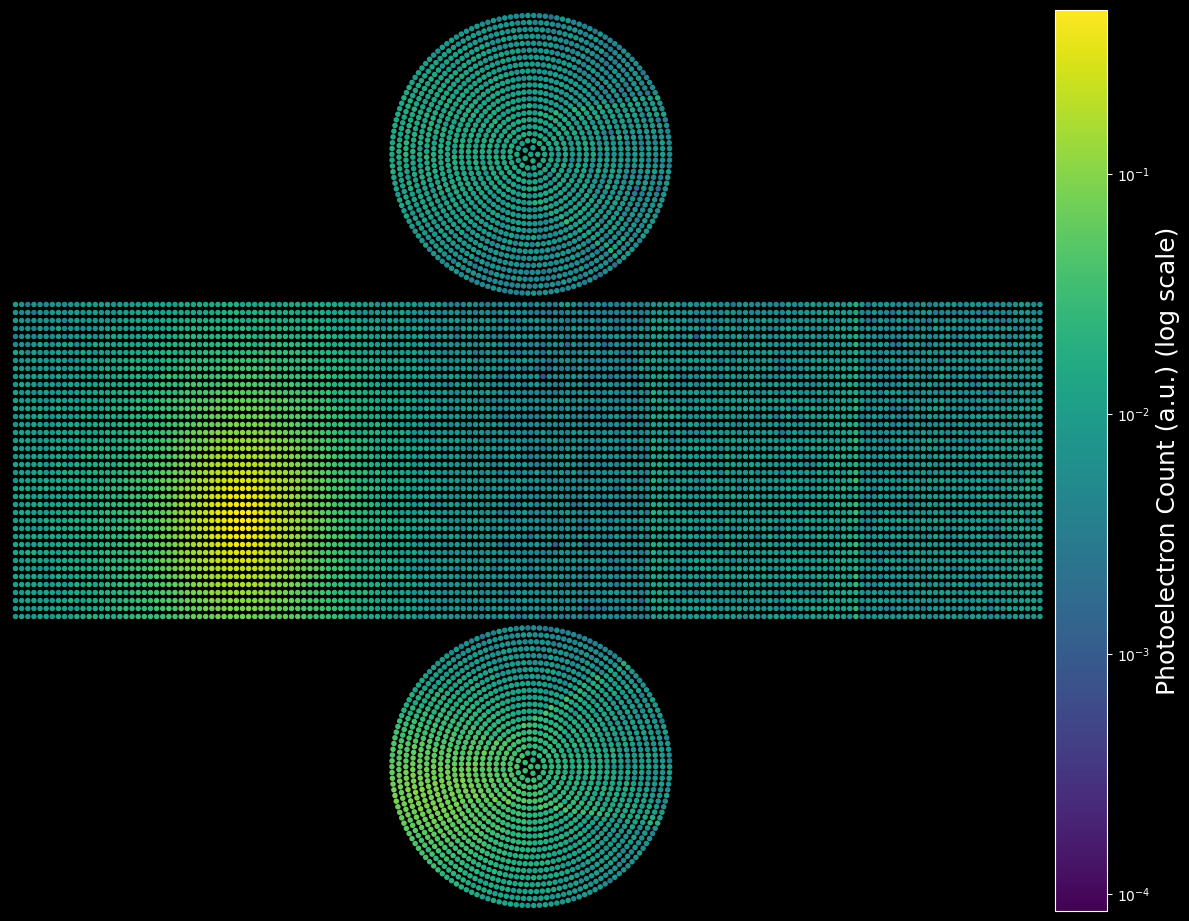

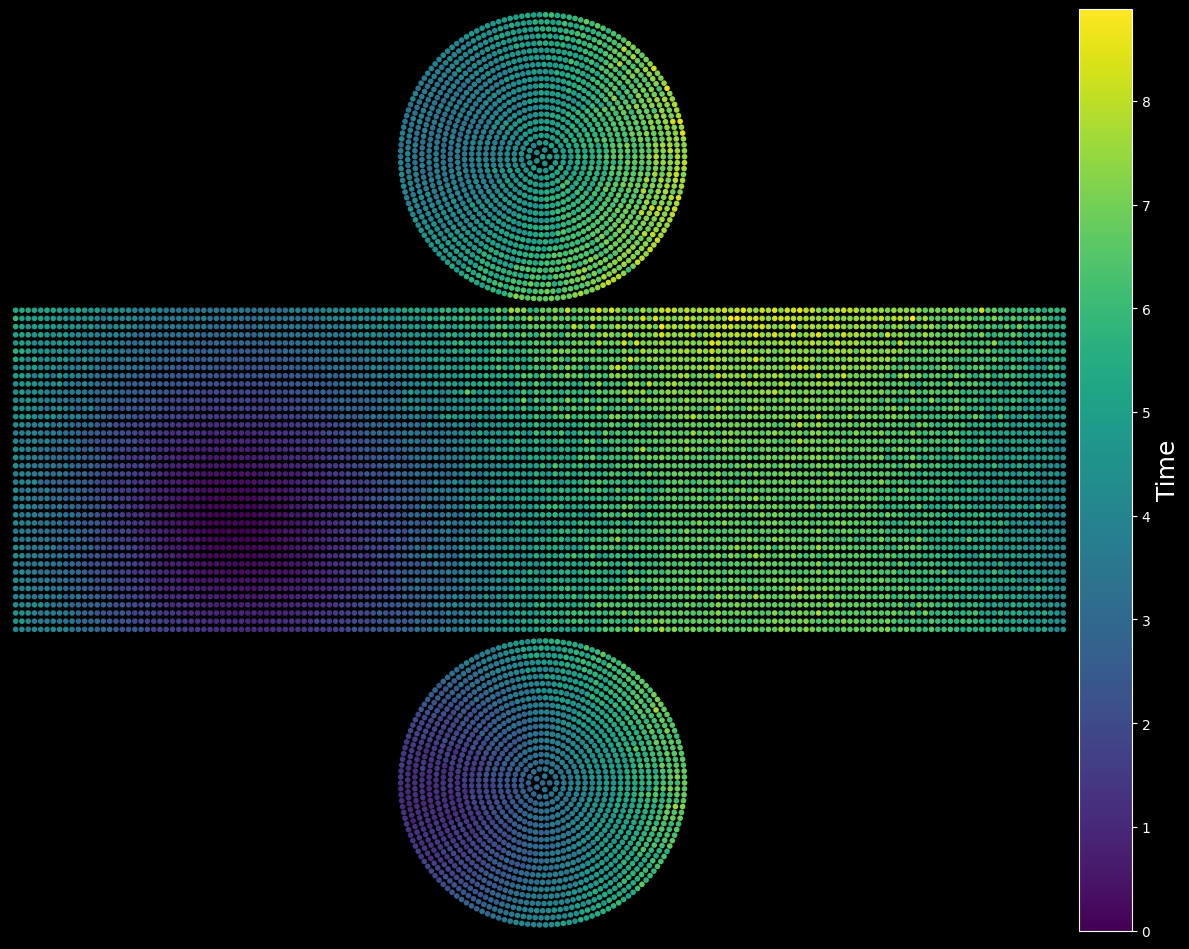

In [8]:
from tools.visualization import create_detector_display
detector_display = create_detector_display(default_json_filename)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='../tools/event_display.png', plot_time=False, log_scale=True)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='../tools/event_display.png', plot_time=True)

In [9]:
%%timeit

key = jax.random.PRNGKey(int(time.time()))

source_origin = generate_random_point_inside_cylinder(key)
source_intensity = 1000

source_params = (source_origin, source_intensity)

single_event_data = simulate_event(source_params, detector_params, key)

837 µs ± 256 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
 print('Total Observed Q: ', jnp.sum(single_event_data[0]))

Total Observed Q:  212.68677


Source origin: [-2.9211395   0.63838995 -1.057248  ]
Source intensity: 1000
Detector Parameters:
────────────────────
Scatter Length: 4.00 m
Reflection Rate: 0.20
Absorption Length: 6.00 m
Simulation Temperature for Gumbel-Softmax: 0.1000
────────────────────
Running analysis with simplified loss function...


Parameters: 100%|██████████| 3/3 [00:41<00:00, 13.88s/it]                         


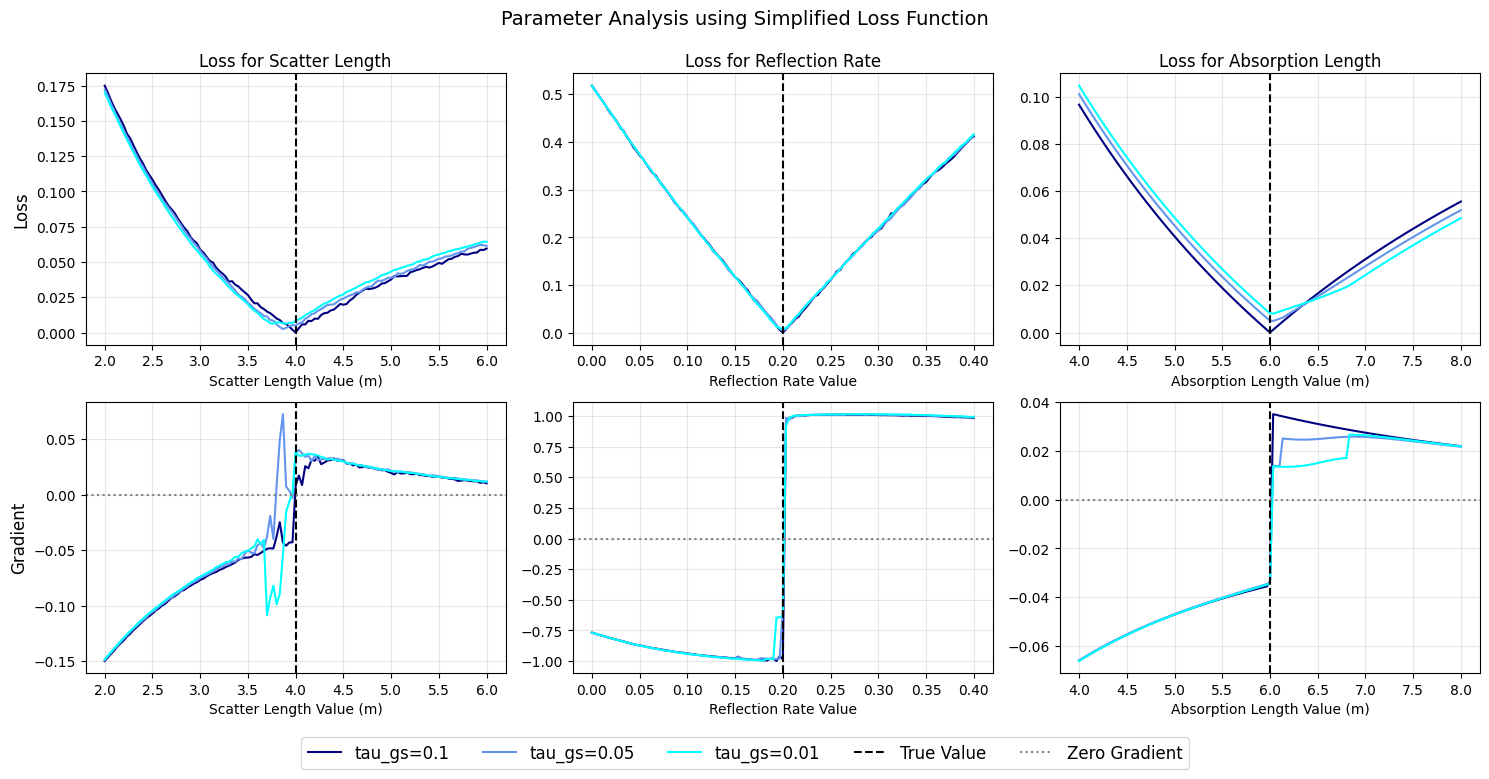

In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import sys

sys.path.append('..')

from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_detector_params, \
    generate_random_point_inside_cylinder
from tools.losses import compute_loss_with_time, compute_simplified_loss, compute_simple_loss, compute_softmin_loss
from tools.simulation import setup_event_simulator

import jax.numpy as jnp
from functools import partial
import pickle
from tqdm import tqdm
import jax
from jax import grad, jit, vmap, value_and_grad
import time
import matplotlib.pyplot as plt

# Define tau_gs values to test (will be set in detector_params[3])
tau_gs_values = [0.1, 0.05, 0.01]

# Generate and save a single event
key_id = 149790000
key = jax.random.PRNGKey(key_id)

# Source parameters (fixed for this analysis)
source_origin = generate_random_point_inside_cylinder(key, r=4, h=6)
source_intensity = 1000
source_params = (source_origin, source_intensity)

# Base detector parameters (will be varied)
base_detector_params = (
    jnp.array(4.),  # scatter_length
    jnp.array(0.2),  # reflection_rate
    jnp.array(6.),  # absorption_length
    jnp.array(0.1)  # tau_gs (will be varied)
)

# Parameter variation ranges
param_changes = (
    jnp.array(2.),  # scatter_length
    jnp.array(0.2),  # reflection_rate
    jnp.array(2.),  # absorption_length
)

# Set up loss functions dictionary for easy reference
loss_functions = {
    'simplified': compute_simplified_loss,
    'simple': compute_simple_loss,
    'softmin': compute_softmin_loss
}

data_detector_params = (
    base_detector_params[0],
    base_detector_params[1],
    base_detector_params[2],
    jnp.array(0.001)
)

# Generate true data using base parameters
true_detector_params = base_detector_params
true_data = jax.lax.stop_gradient(simulate_event(source_params, true_detector_params, key))

# Display parameters
print(f"Source origin: {source_origin}")
print(f"Source intensity: {source_intensity}")
print_detector_params(true_detector_params)


# Function to generate parameter ranges for analysis
def generate_detector_param_ranges(base_params, param_changes, num_points=121):
    param_ranges = []
    for i in range(3):  # Only the first 3 detector parameters (excluding temperature)
        start = max(base_params[i] - param_changes[i], 0.0001)  # Ensure non-negative values
        end = base_params[i] + param_changes[i]
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges


# Create separate JIT-compiled functions for each loss type
def create_loss_and_grad_fn(simulator, source_params, key, true_data, loss_function='simplified'):
    # For simple loss (doesn't need detector_points)
    @jit
    def loss_and_grad_fn_simple(detector_params):
        def inner_loss_fn(d_params):
            simulated_data = simulator(source_params, d_params, key)
            return compute_simple_loss(*true_data, *simulated_data)

        return value_and_grad(inner_loss_fn)(detector_params)

    # For simplified loss (needs detector_points)
    @jit
    def loss_and_grad_fn_simplified(detector_params):
        def inner_loss_fn(d_params):
            simulated_data = simulator(source_params, d_params, key)
            return compute_simplified_loss(detector_points, *true_data, *simulated_data)

        return value_and_grad(inner_loss_fn)(detector_params)

    # For softmin loss (needs detector_points)
    @jit
    def loss_and_grad_fn_softmin(detector_params):
        def inner_loss_fn(d_params):
            simulated_data = simulator(source_params, d_params, key)
            return compute_softmin_loss(detector_points, *true_data, *simulated_data)

        return value_and_grad(inner_loss_fn)(detector_params)

    # Return the appropriate function
    if loss_function == 'simple':
        return loss_and_grad_fn_simple
    elif loss_function == 'softmin':
        return loss_and_grad_fn_softmin
    else:  # Default to simplified
        return loss_and_grad_fn_simplified


# Function to generate plot data for a specific parameter
def generate_plot_data(param_index, param_values, source_params, base_detector_params,
                       tau_gs, key, true_data, loss_function='simplified'):
    losses = []
    gradients = []

    loss_and_grad_fn = create_loss_and_grad_fn(
        simulate_event, source_params, key, true_data, loss_function)

    for new_value in param_values:
        # Create new detector params with varied parameter
        new_d_params = list(base_detector_params)
        new_d_params[param_index] = new_value
        # Set the tau_gs
        new_d_params[3] = jnp.array(tau_gs)
        new_d_params = tuple(new_d_params)

        # Calculate loss and gradient
        loss, grad = loss_and_grad_fn(new_d_params)
        gradient = grad[param_index]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)


# Function to generate all analysis data
def generate_analysis_data(source_params, base_detector_params, param_changes, tau_gs_values,
                           simulator, key, true_data, loss_function='simplified', num_points=121):
    # Generate parameter ranges
    param_ranges = generate_detector_param_ranges(base_detector_params, param_changes, num_points)
    param_names = ['Scatter Length', 'Reflection Rate', 'Absorption Length']

    # Store all data in a dictionary
    analysis_data = {
        'param_ranges': param_ranges,
        'param_names': param_names,
        'source_params': source_params,
        'base_detector_params': base_detector_params,
        'tau_gs_values': tau_gs_values,
        'loss_function': loss_function,
        'results': {}
    }

    # Generate data for each parameter and tau_gs value
    for param_idx, param_name in enumerate(tqdm(param_names, desc="Parameters")):
        param_values = param_ranges[param_idx]
        analysis_data['results'][param_name] = {}

        for tau_gs in tqdm(tau_gs_values, desc=f"Tau_gs values for {param_name}", leave=False):
            losses, gradients = generate_plot_data(
                param_idx, param_values, source_params, base_detector_params,
                tau_gs, key, true_data, loss_function
            )
            analysis_data['results'][param_name][tau_gs] = {
                'losses': losses,
                'gradients': gradients
            }

    return analysis_data


# Function to save analysis data
def save_analysis_data(analysis_data, filename='detector_analysis_data.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(analysis_data, f)


# Function to load analysis data
def load_analysis_data(filename='detector_analysis_data.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# Function to plot analysis results
def plot_analysis_results(analysis_data):
    param_names = analysis_data['param_names']
    tau_gs_values = analysis_data['tau_gs_values']
    base_detector_params = analysis_data['base_detector_params']
    loss_function = analysis_data['loss_function']

    # Define colors for different tau_gs values
    colors = ['navy', 'cornflowerblue', 'cyan']

    # Create a figure with 2 rows (losses and gradients) and 3 columns (parameters)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    # Lists to store legend handles and labels
    all_lines = []
    all_labels = []

    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        param_values = analysis_data['param_ranges'][param_idx]
        true_value = base_detector_params[param_idx]

        ax_loss = axs[0, param_idx]
        ax_grad = axs[1, param_idx]

        for tau_idx, tau_gs in enumerate(tau_gs_values):
            results = analysis_data['results'][param_name][tau_gs]
            losses = results['losses']
            gradients = results['gradients']

            label = f'tau_gs={tau_gs}'
            color = colors[tau_idx]

            # Plot loss and gradient
            line_loss = ax_loss.plot(param_values, losses, color=color, lw=1.5)[0]
            line_grad = ax_grad.plot(param_values, gradients, color=color, lw=1.5)[0]

            # Only store tau_gs-related legend items from the first parameter
            if param_idx == 0:
                all_lines.append(line_loss)
                all_labels.append(label)

        # Add reference lines
        true_line = ax_loss.axvline(x=true_value, color='black', linestyle='--')
        ax_grad.axvline(x=true_value, color='black', linestyle='--')
        zero_line = ax_grad.axhline(y=0, color='gray', linestyle=':')

        # Only store reference lines from the first parameter
        if param_idx == 0:
            all_lines.extend([true_line, zero_line])
            all_labels.extend(['True Value', 'Zero Gradient'])

        # Configure axes
        ax_loss.set_title(f'Loss for {param_name}', pad=5, fontsize=12)

        # Set appropriate x-label based on parameter
        if param_name == 'Scatter Length' or param_name == 'Absorption Length':
            ax_loss.set_xlabel(f'{param_name} Value (m)', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value (m)', fontsize=10)
        else:  # Reflection Rate
            ax_loss.set_xlabel(f'{param_name} Value', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value', fontsize=10)

        # Only add y-label to leftmost plots
        if param_idx == 0:
            ax_loss.set_ylabel('Loss', fontsize=12)
            ax_grad.set_ylabel('Gradient', fontsize=12)

        ax_loss.grid(True, alpha=0.3)
        ax_grad.grid(True, alpha=0.3)

    # Add title with loss function info
    fig.suptitle(f'Parameter Analysis using {loss_function.capitalize()} Loss Function', fontsize=14)

    # Add common legend below all subplots
    fig.legend(all_lines, all_labels,
               loc='lower center',
               bbox_to_anchor=(0.5, 0.02),
               ncol=len(all_lines),
               fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.9)  # Make room for the legend and title

    return fig, axs


# Main execution function
def run_detector_analysis(loss_function='simplified'):
    print(f"Running analysis with {loss_function} loss function...")

    # Generate analysis data
    analysis_data = generate_analysis_data(
        source_params,
        base_detector_params,
        param_changes,
        tau_gs_values,
        simulate_event,  # Single simulator
        key,
        true_data,
        loss_function,
        num_points=121
    )

    # Save the analysis data
    save_analysis_data(analysis_data, f'detector_analysis_{loss_function}.pkl')

    # Plot the results
    fig, axs = plot_analysis_results(analysis_data)
    plt.savefig(f'detector_loss_grads_{loss_function}_{key_id}.pdf', bbox_inches='tight')
    plt.savefig(f'detector_loss_grads_{loss_function}_{key_id}.png', bbox_inches='tight', dpi=300)
    plt.show()

    return analysis_data


# Execute the analysis for each loss function
if __name__ == "__main__":
    for loss_fn in ['simplified']:
        analysis_data = run_detector_analysis(loss_fn)

# To run for a specific loss function only:
# analysis_data = run_detector_analysis('simplified')
# analysis_data = run_detector_analysis('simple')
# analysis_data = run_detector_analysis('softmin')

Starting detector calibration...
True parameters:
  Scatter Length: 4.0000
  Reflection Rate: 0.2000
  Absorption Length: 6.0000
Running PSO with Coordinate Descent refinement...
Phase 1: PSO global search...
Phase 2: Coordinate descent refinement...

Calibration Results:
MSE: 0.000002, Runtime: 40.45s
Scatter Length: 3.9975 (true: 4.0000, error: 0.0025)
Reflection Rate: 0.2002 (true: 0.2000, error: 0.0002)
Absorption Length: 5.9994 (true: 6.0000, error: 0.0006)
PSO Iterations: 100
Coordinate Descent Iterations: 50


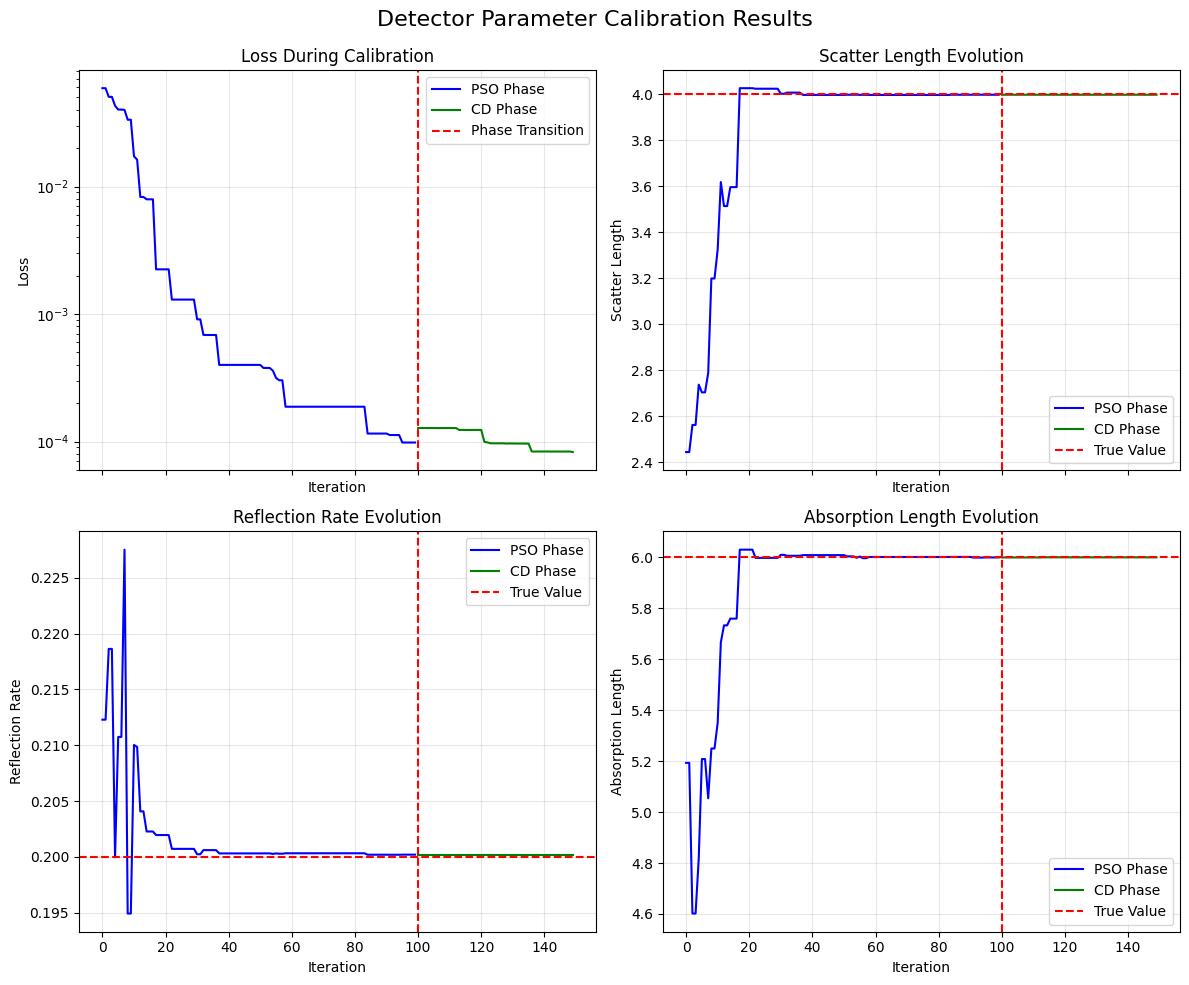

In [12]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, lax, pmap
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from typing import NamedTuple

# Constants
TAU_GS = 0.1
NUM_PSO_ITERATIONS = 100  # PSO phase iterations
NUM_CD_ITERATIONS = 50    # Coordinate descent phase iterations
NUM_PARTICLES = 40        # Number of particles in PSO

# Define bounds as constants
LOWER_BOUNDS = jnp.array([2.0, 0.05, 3.0, -jnp.inf])
UPPER_BOUNDS = jnp.array([6.0, 0.95, 9.0, jnp.inf])

# PSO State structure using NamedTuple for compatibility
class PSOState(NamedTuple):
    positions: jnp.ndarray      # Shape: (n_particles, n_dims)
    velocities: jnp.ndarray     # Shape: (n_particles, n_dims)
    personal_best_positions: jnp.ndarray  # Shape: (n_particles, n_dims)
    personal_best_fitness: jnp.ndarray    # Shape: (n_particles,)
    global_best_position: jnp.ndarray     # Shape: (n_dims,)
    global_best_fitness: float
    key: jax.random.PRNGKey

# Coordinate Descent State
class CDState(NamedTuple):
    position: jnp.ndarray
    fitness: float
    step_sizes: jnp.ndarray
    improved: bool

# Add this at the top with other imports
class CDHistory(NamedTuple):
    positions: jnp.ndarray
    fitness: jnp.ndarray
    iterations: jnp.ndarray

# JIT-compiled utility functions
@jit
def apply_constraints_vectorized(params):
    """Apply boundary constraints to parameters in a vectorized way."""
    return jnp.clip(params, LOWER_BOUNDS, UPPER_BOUNDS)

@partial(jit, static_argnums=(2, 3))
def initialize_pso_state(key, initial_guess, n_particles, tau_gs):
    """Initialize PSO state with particles."""
    key1, key2 = jax.random.split(key)

    # Initialize positions around initial guess
    position_noise = jax.random.uniform(key1, (n_particles, 4), minval=-0.3, maxval=0.3)
    positions = initial_guess * (1 + position_noise)
    positions = positions.at[:, 3].set(tau_gs)  # Fix tau_gs
    positions = apply_constraints_vectorized(positions)

    # Initialize velocities
    velocity_noise = jax.random.uniform(key2, (n_particles, 4), minval=-0.1, maxval=0.1)
    velocities = initial_guess * velocity_noise
    velocities = velocities.at[:, 3].set(0.0)  # Fix tau_gs velocity

    # Initialize bests
    personal_best_positions = positions
    personal_best_fitness = jnp.full(n_particles, jnp.inf)
    global_best_position = positions[0]
    global_best_fitness = jnp.inf

    return PSOState(
        positions=positions,
        velocities=velocities,
        personal_best_positions=personal_best_positions,
        personal_best_fitness=personal_best_fitness,
        global_best_position=global_best_position,
        global_best_fitness=global_best_fitness,
        key=key
    )

@partial(jit, static_argnums=(1, 3, 4, 5))
def pso_update_step(state, loss_fn_vectorized, global_best_position, w, c1, c2):
    """Single PSO update step - fully vectorized."""
    # Evaluate all particles
    fitness_values = loss_fn_vectorized(state.positions)

    # Update personal bests
    improved_mask = fitness_values < state.personal_best_fitness
    personal_best_positions = jnp.where(
        improved_mask[:, None],
        state.positions,
        state.personal_best_positions
    )
    personal_best_fitness = jnp.where(
        improved_mask,
        fitness_values,
        state.personal_best_fitness
    )

    # Update global best
    global_best_idx = jnp.argmin(personal_best_fitness)
    new_global_best_position = personal_best_positions[global_best_idx]
    new_global_best_fitness = personal_best_fitness[global_best_idx]

    # Generate random values for velocity update
    key1, key2, key3 = jax.random.split(state.key, 3)
    r1 = jax.random.uniform(key1, state.positions.shape)
    r2 = jax.random.uniform(key2, state.positions.shape)

    # Update velocities (vectorized)
    cognitive = c1 * r1 * (personal_best_positions - state.positions)
    social = c2 * r2 * (global_best_position - state.positions)
    new_velocities = w * state.velocities + cognitive + social
    new_velocities = new_velocities.at[:, 3].set(0.0)  # Keep tau_gs velocity at 0

    # Update positions
    new_positions = state.positions + new_velocities
    new_positions = apply_constraints_vectorized(new_positions)

    # Create new state
    return PSOState(
        positions=new_positions,
        velocities=new_velocities,
        personal_best_positions=personal_best_positions,
        personal_best_fitness=personal_best_fitness,
        global_best_position=new_global_best_position,
        global_best_fitness=new_global_best_fitness,
        key=key3
    )

@partial(jit, static_argnums=(1, 2, 3, 4, 5))
def pso_main_loop(initial_state, loss_fn_vectorized, w, c1, c2, n_iterations):
    """Main PSO loop using lax.scan."""
    def scan_fn(state, _):
        new_state = pso_update_step(state, loss_fn_vectorized, state.global_best_position, w, c1, c2)
        # Create history record
        history_record = PSOState(
            positions=new_state.positions,
            velocities=new_state.velocities,
            personal_best_positions=new_state.personal_best_positions,
            personal_best_fitness=new_state.personal_best_fitness,
            global_best_position=new_state.global_best_position,
            global_best_fitness=new_state.global_best_fitness,
            key=new_state.key
        )
        return new_state, history_record

    final_state, history = lax.scan(scan_fn, initial_state, jnp.arange(n_iterations))
    return final_state, history

@partial(jit, static_argnums=(1,))
def coordinate_descent_single_param(position, loss_fn, param_idx, step_size):
    """Update a single parameter using coordinate descent."""
    # Create candidate positions
    pos_step = position.at[param_idx].add(step_size)
    neg_step = position.at[param_idx].add(-step_size)

    # Apply constraints
    pos_step = apply_constraints_vectorized(pos_step)
    neg_step = apply_constraints_vectorized(neg_step)

    # Evaluate all three positions
    current_fitness = loss_fn(position)
    pos_fitness = loss_fn(pos_step)
    neg_fitness = loss_fn(neg_step)

    # Find best position
    fitnesses = jnp.array([current_fitness, pos_fitness, neg_fitness])
    positions = jnp.stack([position, pos_step, neg_step])
    best_idx = jnp.argmin(fitnesses)

    # Select best position and fitness
    best_position = positions[best_idx]
    best_fitness = fitnesses[best_idx]
    improved = best_fitness < current_fitness

    return best_position, best_fitness, improved

@partial(jit, static_argnums=(1,))
def coordinate_descent_iteration(state, loss_fn):
    """One complete iteration through all parameters."""
    # Update each parameter sequentially
    position = state.position
    fitness = state.fitness
    any_improved = False

    # Parameter 0
    position, fitness, improved0 = coordinate_descent_single_param(
        position, loss_fn, 0, state.step_sizes[0])
    any_improved = any_improved | improved0

    # Parameter 1
    position, fitness, improved1 = coordinate_descent_single_param(
        position, loss_fn, 1, state.step_sizes[1])
    any_improved = any_improved | improved1

    # Parameter 2
    position, fitness, improved2 = coordinate_descent_single_param(
        position, loss_fn, 2, state.step_sizes[2])
    any_improved = any_improved | improved2

    # Update step sizes
    step_reduction = jnp.array([0.7, 0.9, 0.7, 1.0])
    new_step_sizes = jnp.where(
        any_improved,
        state.step_sizes,
        state.step_sizes * step_reduction
    )

    return CDState(
        position=position,
        fitness=fitness,
        step_sizes=new_step_sizes,
        improved=any_improved
    )

# Add this at the top with other imports
class CDHistory(NamedTuple):
    positions: jnp.ndarray
    fitness: jnp.ndarray
    iterations: jnp.ndarray

@partial(jit, static_argnums=(0, 3))
def coordinate_descent_phase(loss_fn, initial_position, initial_fitness, n_iterations):
    """Run coordinate descent phase."""
    # Initialize step sizes
    initial_step_sizes = jnp.array([
        initial_position[0] * 0.01,    # scatter
        initial_position[1] * 0.0002,  # reflection (smaller due to sensitivity)
        initial_position[2] * 0.01,    # absorption
        0.0                            # tau_gs (fixed)
    ])

    # Minimum step sizes
    min_step_sizes = jnp.array([0.01, 0.0001, 0.01, 0.0])
    initial_step_sizes = jnp.maximum(initial_step_sizes, min_step_sizes)

    initial_state = CDState(
        position=initial_position,
        fitness=initial_fitness,
        step_sizes=initial_step_sizes,
        improved=True
    )

    def scan_fn(state, _):
        new_state = coordinate_descent_iteration(state, loss_fn)
        return new_state, new_state

    final_state, history = lax.scan(scan_fn, initial_state, jnp.arange(n_iterations))

    # Calculate convergence without Python conditionals
    step_threshold = jnp.array([1e-7, 2e-9, 1e-7, 0.0])
    converged = jnp.all(history.step_sizes < step_threshold, axis=1)
    # Use JAX operations instead of Python conditionals
    first_converged = jnp.argmax(converged)
    any_converged = jnp.any(converged)
    iterations = jnp.where(any_converged, first_converged, n_iterations)

    # Return a proper NamedTuple
    cd_history = CDHistory(
        positions=history.position,
        fitness=history.fitness,
        iterations=iterations
    )

    return final_state.position, final_state.fitness, cd_history

def pso_with_coordinate_refinement(source_params, true_data, initial_guess, key):
    """
    Two-phase optimization:
    1. Standard PSO for global search
    2. Coordinate descent for precise refinement
    """
    print("Running PSO with Coordinate Descent refinement...")

    # Create loss function that captures necessary parameters
    def create_loss_fn(detector_points, source_params, key):
        @jit
        def loss_fn(params):
            return compute_simplified_loss(
                detector_points,
                *true_data,
                *simulate_event(source_params, params, key)
            )
        return loss_fn

    # Create the loss function
    loss_fn = create_loss_fn(detector_points, source_params, key)

    # Vectorized loss function for multiple particles
    loss_fn_vectorized = vmap(loss_fn)

    # ------- PHASE 1: PARTICLE SWARM OPTIMIZATION -------
    print("Phase 1: PSO global search...")

    # PSO parameters
    w = 0.7    # Inertia weight
    c1 = 1.5   # Cognitive coefficient
    c2 = 1.5   # Social coefficient

    # Initialize PSO state
    key, pso_key = jax.random.split(key)
    state = initialize_pso_state(pso_key, initial_guess, NUM_PARTICLES, TAU_GS)

    # Run PSO main loop using lax.scan
    state, history = pso_main_loop(state, loss_fn_vectorized, w, c1, c2, NUM_PSO_ITERATIONS)

    # Extract history
    position_history = history.global_best_position
    fitness_history = history.global_best_fitness

    # Count actual PSO iterations (before convergence)
    converged_mask = fitness_history < 1e-6
    pso_iterations = jnp.where(
        jnp.any(converged_mask),
        jnp.argmax(converged_mask),
        NUM_PSO_ITERATIONS
    )

    # ------- PHASE 2: COORDINATE DESCENT REFINEMENT -------
    print("Phase 2: Coordinate descent refinement...")

    # Start from the best position found by PSO
    current_position = state.global_best_position
    current_fitness = state.global_best_fitness

    # Run coordinate descent
    final_position, final_fitness, cd_history = coordinate_descent_phase(
        loss_fn, current_position, current_fitness, NUM_CD_ITERATIONS
    )

    # Combine histories
    full_position_history = jnp.concatenate([
        position_history[:pso_iterations],
        cd_history.positions
    ])
    full_fitness_history = jnp.concatenate([
        fitness_history[:pso_iterations],
        cd_history.fitness
    ])

    # Return results
    return {
        'final_params': final_position,
        'final_loss': final_fitness,
        'position_history': full_position_history,
        'loss_history': full_fitness_history,
        'pso_iterations': pso_iterations,
        'cd_iterations': cd_history.iterations,
        'converged': pso_iterations < NUM_PSO_ITERATIONS
    }

def calibrate_detector_parameters(initial_guess, true_params=None):
    """
    Calibrate detector parameters using PSO + coordinate descent.

    Args:
        initial_guess: Initial guess for detector parameters
        true_params: True parameters (if known, for evaluation)

    Returns:
        dict: Results including calibrated parameters, MSE, etc.
    """
    print("Starting detector calibration...")
    start_time = time.time()

    # Create random key
    key = jax.random.PRNGKey(42)  # Use fixed seed for reproducibility
    key_source, key_data = jax.random.split(key)

    # Generate source parameters
    source_origin = generate_random_point_inside_cylinder(key_source, r=4, h=6)
    source_intensity = 1000
    source_params = (source_origin, source_intensity)

    # If true parameters are not provided, generate random ones
    if true_params is None:
        # Generate random true parameters
        true_scatter_key, true_reflect_key, true_absorb_key, key = jax.random.split(key, 4)
        true_scatter = jax.random.uniform(true_scatter_key, minval=3.0, maxval=5.0)
        true_reflect = jax.random.uniform(true_reflect_key, minval=0.15, maxval=0.25)
        true_absorb = jax.random.uniform(true_absorb_key, minval=5.0, maxval=7.0)

        true_params = jnp.array([true_scatter, true_reflect, true_absorb, TAU_GS])

    else:
        true_params = jnp.array(true_params)

    # Print true parameters
    print(f"True parameters:")
    print(f"  Scatter Length: {true_params[0]:.4f}")
    print(f"  Reflection Rate: {true_params[1]:.4f}")
    print(f"  Absorption Length: {true_params[2]:.4f}")

    # Generate true data
    true_data = simulate_event(source_params, true_params, key_data)

    # Convert initial guess to JAX array
    initial_guess = jnp.array(initial_guess)

    # Run optimization
    results = pso_with_coordinate_refinement(source_params, true_data, initial_guess, key_data)

    # Extract final parameters
    final_params = results['final_params']

    # Calculate parameter errors
    param_errors = jnp.abs(final_params[:3] - true_params[:3])
    mse = jnp.mean(param_errors**2)

    # Calculate runtime
    end_time = time.time()
    runtime = end_time - start_time

    # Add results
    results['mse'] = float(mse)
    results['param_errors'] = param_errors.tolist()
    results['runtime'] = runtime
    results['true_params'] = true_params

    # Print results
    print("\nCalibration Results:")
    print(f"MSE: {mse:.6f}, Runtime: {runtime:.2f}s")
    print(f"Scatter Length: {final_params[0]:.4f} (true: {true_params[0]:.4f}, error: {param_errors[0]:.4f})")
    print(f"Reflection Rate: {final_params[1]:.4f} (true: {true_params[1]:.4f}, error: {param_errors[1]:.4f})")
    print(f"Absorption Length: {final_params[2]:.4f} (true: {true_params[2]:.4f}, error: {param_errors[2]:.4f})")
    print(f"PSO Iterations: {int(results['pso_iterations'])}")
    print(f"Coordinate Descent Iterations: {int(results['cd_iterations'])}")

    # Plot results
    plot_calibration_results(results)

    return results

def plot_calibration_results(results):
    """
    Plot calibration results in a 2x2 grid:
    - Loss history
    - Scatter length evolution
    - Reflection rate evolution
    - Absorption length evolution
    """
    # Extract data
    position_history = results['position_history']
    loss_history = results['loss_history']
    true_params = results['true_params']
    pso_iterations = int(results['pso_iterations'])
    total_iterations = len(loss_history)

    # Calculate where PSO ends and CD begins
    phase_transition = pso_iterations

    # Extract parameter histories
    scatter_history = position_history[:, 0]
    reflect_history = position_history[:, 1]
    absorb_history = position_history[:, 2]

    # Create figure with 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

    # Plot 1: Loss history (top-left)
    ax_loss = axes[0, 0]
    ax_loss.plot(range(phase_transition), loss_history[:phase_transition],
                 'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_loss.plot(range(phase_transition, total_iterations),
                     loss_history[phase_transition:], 'g-', label='CD Phase')
        ax_loss.axvline(x=phase_transition, color='r', linestyle='--', label='Phase Transition')
    ax_loss.set_xlabel('Iteration')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Loss During Calibration')
    ax_loss.grid(alpha=0.3)
    ax_loss.set_yscale('log')
    ax_loss.legend()

    # Plot 2: Scatter length evolution (top-right)
    ax_scatter = axes[0, 1]
    ax_scatter.plot(range(phase_transition), scatter_history[:phase_transition],
                    'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_scatter.plot(range(phase_transition, total_iterations),
                        scatter_history[phase_transition:], 'g-', label='CD Phase')
        ax_scatter.axvline(x=phase_transition, color='r', linestyle='--')
    ax_scatter.axhline(y=true_params[0], color='r', linestyle='--', label='True Value')
    ax_scatter.set_xlabel('Iteration')
    ax_scatter.set_ylabel('Scatter Length')
    ax_scatter.set_title('Scatter Length Evolution')
    ax_scatter.grid(alpha=0.3)
    ax_scatter.legend()

    # Plot 3: Reflection rate evolution (bottom-left)
    ax_reflect = axes[1, 0]
    ax_reflect.plot(range(phase_transition), reflect_history[:phase_transition],
                    'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_reflect.plot(range(phase_transition, total_iterations),
                        reflect_history[phase_transition:], 'g-', label='CD Phase')
        ax_reflect.axvline(x=phase_transition, color='r', linestyle='--')
    ax_reflect.axhline(y=true_params[1], color='r', linestyle='--', label='True Value')
    ax_reflect.set_xlabel('Iteration')
    ax_reflect.set_ylabel('Reflection Rate')
    ax_reflect.set_title('Reflection Rate Evolution')
    ax_reflect.grid(alpha=0.3)
    ax_reflect.legend()

    # Plot 4: Absorption length evolution (bottom-right)
    ax_absorb = axes[1, 1]
    ax_absorb.plot(range(phase_transition), absorb_history[:phase_transition],
                   'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_absorb.plot(range(phase_transition, total_iterations),
                       absorb_history[phase_transition:], 'g-', label='CD Phase')
        ax_absorb.axvline(x=phase_transition, color='r', linestyle='--')
    ax_absorb.axhline(y=true_params[2], color='r', linestyle='--', label='True Value')
    ax_absorb.set_xlabel('Iteration')
    ax_absorb.set_ylabel('Absorption Length')
    ax_absorb.set_title('Absorption Length Evolution')
    ax_absorb.grid(alpha=0.3)
    ax_absorb.legend()

    # Add overall title
    fig.suptitle('Detector Parameter Calibration Results', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # Save the figure
    plt.savefig('calibration_results.png', dpi=300)
    plt.show()

def run_detector_calibration(true_params=None, initial_guess=None):
    """
    Run detector calibration with default or specified parameters.

    Args:
        true_params: True parameters (if None, random parameters will be generated)
        initial_guess: Initial guess (if None, perturbed true parameters will be used)

    Returns:
        dict: Calibration results
    """
    # If initial guess is not provided, use default or generate based on true parameters
    if initial_guess is None:
        if true_params is not None:
            # Perturb true parameters by 25% to create initial guess
            key = jax.random.PRNGKey(0)
            noise = jax.random.uniform(key, (3,), minval=-0.25, maxval=0.25)
            initial_guess = jnp.array([
                true_params[0] * (1 + noise[0]),
                true_params[1] * (1 + noise[1]),
                true_params[2] * (1 + noise[2]),
                TAU_GS
            ])
        else:
            # Default initial guess
            initial_guess = jnp.array([4.0, 0.2, 6.0, TAU_GS])

    # Run calibration
    results = calibrate_detector_parameters(initial_guess, true_params)

    return results

# Run the calibration
if __name__ == "__main__":
    # Define known true parameters for testing
    true_params = jnp.array([4.0, 0.2, 6.0, TAU_GS])

    # Define initial guess
    initial_guess = jnp.array([2.0, 0.3, 4.0, TAU_GS])

    # Run calibration
    results = run_detector_calibration(true_params, initial_guess)

In [ ]:
# Define multiple test cases (updated)
def create_test_cases():
    """Create 4 different test cases with varying conditions."""
    test_cases = []

    # Case 1: Easy case - initial guess close to true values
    case1 = {
        'name': 'Easy Case',
        'true_params': jnp.array([4.0, 0.2, 6.0, TAU_GS]),
        'initial_guess': jnp.array([3.8, 0.19, 5.8, TAU_GS]),
        'color': 'blue',
        'label': 'Easy: Close Initial Guess'
    }
    test_cases.append(case1)

    # Case 2: Medium case - moderate offset
    case2 = {
        'name': 'Medium Case',
        'true_params': jnp.array([3.5, 0.25, 7.0, TAU_GS]),
        'initial_guess': jnp.array([4.5, 0.18, 5.5, TAU_GS]),
        'color': 'green',
        'label': 'Medium: Moderate Offset'
    }
    test_cases.append(case2)

    # Case 3: Hard case - large offset
    case3 = {
        'name': 'Hard Case',
        'true_params': jnp.array([5.0, 0.15, 5.0, TAU_GS]),
        'initial_guess': jnp.array([3.0, 0.35, 8.0, TAU_GS]),
        'color': 'red',
        'label': 'Hard: Large Offset'
    }
    test_cases.append(case3)

    # Case 4: Very Hard case - extreme offset with challenging parameter values
    case4 = {
        'name': 'Hard Case',
        'true_params': jnp.array([2.2, 0.35, 8.8, TAU_GS]),
        'initial_guess': jnp.array([5.8, 0.18, 3.2, TAU_GS]),
        'color': 'purple',
        'label': 'Very Hard: Extreme Offset'
    }
    test_cases.append(case4)

    return test_cases

def plot_multi_calibration_results(results_list, labels, colors):
    """
    Plot calibration results for multiple runs (with different true parameters) in a 2x2 grid.

    Args:
        results_list: List of result dictionaries from calibration
        labels: List of labels for each result set
        colors: List of colors for each result set
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

    # Plot titles and labels
    axes[0, 0].set_title('Loss During Calibration', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Iteration', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_yscale('log')

    axes[0, 1].set_title('Scatter Length Evolution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Iteration', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Scatter Length (m)', fontsize=12, fontweight='bold')

    axes[1, 0].set_title('Reflection Rate Evolution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Iteration', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Reflection Rate', fontsize=12, fontweight='bold')

    axes[1, 1].set_title('Absorption Length Evolution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Iteration', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Absorption Length (m)', fontsize=12, fontweight='bold')

    # Plot each set of results
    for i, results in enumerate(results_list):
        # Extract data
        position_history = results['position_history']
        loss_history = results['loss_history']
        true_params = results['true_params']
        total_iterations = len(loss_history)

        # Convert position history to parameter arrays
        scatter_history = [float(p[0]) for p in position_history]
        reflect_history = [float(p[1]) for p in position_history]
        absorb_history = [float(p[2]) for p in position_history]

        # Plot histories
        axes[0, 0].plot(range(total_iterations), loss_history, color=colors[i], label=labels[i], linewidth=1.5)
        axes[0, 1].plot(range(total_iterations), scatter_history, color=colors[i], label=labels[i], linewidth=1.5)
        axes[1, 0].plot(range(total_iterations), reflect_history, color=colors[i], label=labels[i], linewidth=1.5)
        axes[1, 1].plot(range(total_iterations), absorb_history, color=colors[i], label=labels[i], linewidth=1.5)

        # Plot true value lines
        axes[0, 1].axhline(y=float(true_params[0]), color=colors[i], linestyle='--', alpha=0.7, linewidth=1.5)
        axes[1, 0].axhline(y=float(true_params[1]), color=colors[i], linestyle='--', alpha=0.7, linewidth=1.5)
        axes[1, 1].axhline(y=float(true_params[2]), color=colors[i], linestyle='--', alpha=0.7, linewidth=1.5)

    # Set tick parameters and grid (no legends as requested)
    for ax in axes.flatten():
        ax.tick_params(labelsize=10)
        ax.grid(alpha=0.3)

    # Add overall title
    fig.suptitle('Detector Parameter Calibration Results', fontsize=16, fontweight='bold')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # Save the figure
    plt.savefig('multi_true_params_calibration.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_summary_table(results_list):
    """Create a summary table of all results."""
    print("\n" + "="*70)
    print("CALIBRATION SUMMARY")
    print("="*70)
    print(f"{'Case':<15} {'MSE':<12} {'Scatter Err':<12} {'Reflect Err':<12} {'Absorb Err':<12}")
    print("-"*70)

    for results in results_list:
        case_name = results['case_name']
        mse = results['mse']
        errors = results['param_errors']
        print(f"{case_name:<15} {mse:<12.6f} {errors[0]:<12.6f} {errors[1]:<12.6f} {errors[2]:<12.6f}")

    print("="*70)

# Updated run function to use new plotting style
def run_multi_case_analysis():
    """Run the complete multi-case analysis."""
    # Create test cases
    test_cases = create_test_cases()

    # Extract labels and colors
    labels = [case['label'] for case in test_cases]
    colors = [case['color'] for case in test_cases]

    # Run calibrations
    results_list = []
    for i, case in enumerate(test_cases):
        print(f"\n{'='*50}")
        print(f"Running Test Case {i+1}: {case['name']}")
        print(f"{'='*50}")

        # Run calibration
        results = run_detector_calibration(
            true_params=case['true_params'],
            initial_guess=case['initial_guess']
        )

        # Add case information to results
        results['case_name'] = case['name']
        results['color'] = case['color']
        results['label'] = case['label']
        results['initial_guess'] = case['initial_guess']

        results_list.append(results)

    # Create summary table
    create_summary_table(results_list)

    # Plot all results together using new style
    plot_multi_calibration_results(results_list, labels, colors)

    return results_list

# Run the analysis
if __name__ == "__main__":
    results_list = run_multi_case_analysis()


Running Test Case 1: Easy Case
Starting detector calibration...
True parameters:
  Scatter Length: 4.0000
  Reflection Rate: 0.2000
  Absorption Length: 6.0000
Running PSO with Coordinate Descent refinement...
Phase 1: PSO global search...
Phase 2: Coordinate descent refinement...


Starting detector calibration...
True parameters:
  Scatter Length: 4.0000
  Reflection Rate: 0.2000
  Absorption Length: 6.0000
Running PSO with Adam refinement...
Phase 1: PSO global search...
Phase 2: Adam optimizer refinement with diagonal preconditioning...

Calibration Results:
MSE: 0.000001, Runtime: 27.05s
Scatter Length: 3.9987 (true: 4.0000, error: 0.0013)
Reflection Rate: 0.2001 (true: 0.2000, error: 0.0001)
Absorption Length: 5.9988 (true: 6.0000, error: 0.0012)
PSO Iterations: 100
Adam Iterations: 100


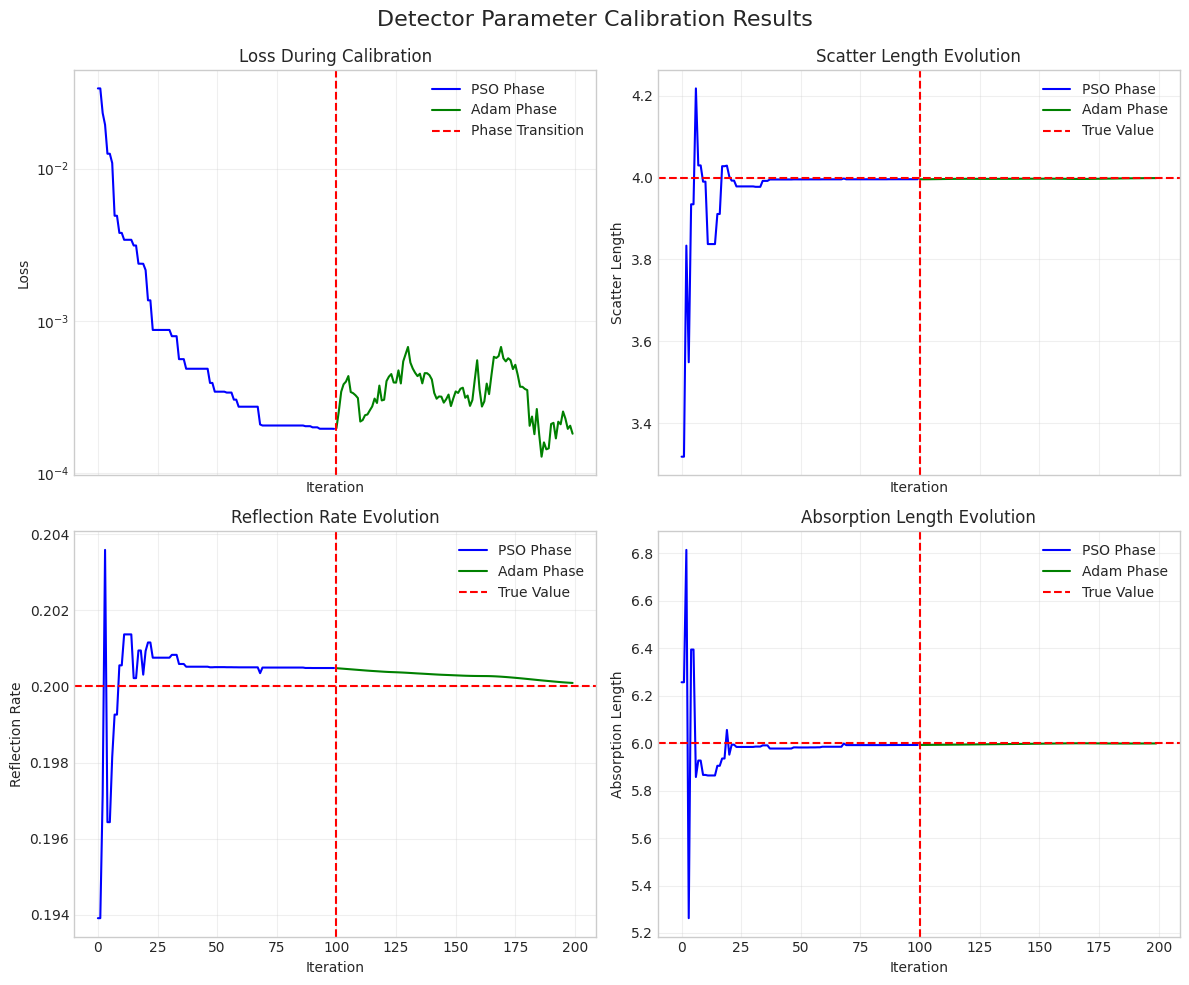

In [30]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, lax, pmap
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from typing import NamedTuple
import optax

# Constants
TAU_GS = 0.1
NUM_PSO_ITERATIONS = 100  # PSO phase iterations
NUM_ADAM_ITERATIONS = 100  # Adam optimizer iterations
NUM_PARTICLES = 40        # Number of particles in PSO

# Define bounds as constants
LOWER_BOUNDS = jnp.array([2.0, 0.05, 3.0, -jnp.inf])
UPPER_BOUNDS = jnp.array([6.0, 0.4, 9.0, jnp.inf])

# Define per-parameter learning rate scaling
# Since reflection parameter has ~50x larger gradients, we scale it down
PARAM_LR_SCALE = jnp.array([1.0, 0.05, 1.0, 0.0])  # [scatter, reflect, absorb, tau_gs]

# PSO State structure using NamedTuple for compatibility
class PSOState(NamedTuple):
    positions: jnp.ndarray      # Shape: (n_particles, n_dims)
    velocities: jnp.ndarray     # Shape: (n_particles, n_dims)
    personal_best_positions: jnp.ndarray  # Shape: (n_particles, n_dims)
    personal_best_fitness: jnp.ndarray    # Shape: (n_particles,)
    global_best_position: jnp.ndarray     # Shape: (n_dims,)
    global_best_fitness: float
    key: jax.random.PRNGKey

# Adam History structure
class AdamHistory(NamedTuple):
    positions: jnp.ndarray
    fitness: jnp.ndarray
    iterations: jnp.ndarray

# JIT-compiled utility functions
@jit
def apply_constraints_vectorized(params):
    """Apply boundary constraints to parameters in a vectorized way."""
    return jnp.clip(params, LOWER_BOUNDS, UPPER_BOUNDS)

@partial(jit, static_argnums=(2, 3))
def initialize_pso_state(key, initial_guess, n_particles, tau_gs):
    """Initialize PSO state with particles."""
    key1, key2 = jax.random.split(key)

    # Initialize positions around initial guess
    position_noise = jax.random.uniform(key1, (n_particles, 4), minval=-0.3, maxval=0.3)
    positions = initial_guess * (1 + position_noise)
    positions = positions.at[:, 3].set(tau_gs)  # Fix tau_gs
    positions = apply_constraints_vectorized(positions)

    # Initialize velocities
    velocity_noise = jax.random.uniform(key2, (n_particles, 4), minval=-0.1, maxval=0.1)
    velocities = initial_guess * velocity_noise
    velocities = velocities.at[:, 3].set(0.0)  # Fix tau_gs velocity

    # Initialize bests
    personal_best_positions = positions
    personal_best_fitness = jnp.full(n_particles, jnp.inf)
    global_best_position = positions[0]
    global_best_fitness = jnp.inf

    return PSOState(
        positions=positions,
        velocities=velocities,
        personal_best_positions=personal_best_positions,
        personal_best_fitness=personal_best_fitness,
        global_best_position=global_best_position,
        global_best_fitness=global_best_fitness,
        key=key
    )

@partial(jit, static_argnums=(1, 3, 4, 5))
def pso_update_step(state, loss_fn_vectorized, global_best_position, w, c1, c2):
    """Single PSO update step - fully vectorized."""
    # Evaluate all particles
    fitness_values = loss_fn_vectorized(state.positions)

    # Update personal bests
    improved_mask = fitness_values < state.personal_best_fitness
    personal_best_positions = jnp.where(
        improved_mask[:, None],
        state.positions,
        state.personal_best_positions
    )
    personal_best_fitness = jnp.where(
        improved_mask,
        fitness_values,
        state.personal_best_fitness
    )

    # Update global best
    global_best_idx = jnp.argmin(personal_best_fitness)
    new_global_best_position = personal_best_positions[global_best_idx]
    new_global_best_fitness = personal_best_fitness[global_best_idx]

    # Generate random values for velocity update
    key1, key2, key3 = jax.random.split(state.key, 3)
    r1 = jax.random.uniform(key1, state.positions.shape)
    r2 = jax.random.uniform(key2, state.positions.shape)

    # Update velocities (vectorized)
    cognitive = c1 * r1 * (personal_best_positions - state.positions)
    social = c2 * r2 * (global_best_position - state.positions)
    new_velocities = w * state.velocities + cognitive + social
    new_velocities = new_velocities.at[:, 3].set(0.0)  # Keep tau_gs velocity at 0

    # Update positions
    new_positions = state.positions + new_velocities
    new_positions = apply_constraints_vectorized(new_positions)

    # Create new state
    return PSOState(
        positions=new_positions,
        velocities=new_velocities,
        personal_best_positions=personal_best_positions,
        personal_best_fitness=personal_best_fitness,
        global_best_position=new_global_best_position,
        global_best_fitness=new_global_best_fitness,
        key=key3
    )

@partial(jit, static_argnums=(1, 2, 3, 4, 5))
def pso_main_loop(initial_state, loss_fn_vectorized, w, c1, c2, n_iterations):
    """Main PSO loop using lax.scan."""
    def scan_fn(state, _):
        new_state = pso_update_step(state, loss_fn_vectorized, state.global_best_position, w, c1, c2)
        # Create history record
        history_record = PSOState(
            positions=new_state.positions,
            velocities=new_state.velocities,
            personal_best_positions=new_state.personal_best_positions,
            personal_best_fitness=new_state.personal_best_fitness,
            global_best_position=new_state.global_best_position,
            global_best_fitness=new_state.global_best_fitness,
            key=new_state.key
        )
        return new_state, history_record

    final_state, history = lax.scan(scan_fn, initial_state, jnp.arange(n_iterations))
    return final_state, history

@partial(jit, static_argnums=(0, 3))
def adam_optimization_phase(loss_fn, initial_position, initial_fitness, n_iterations,
                           base_learning_rate=0.01, param_scale=None):
    """Run Adam optimization phase using optax with diagonal preconditioning."""

    if param_scale is None:
        param_scale = jnp.ones(4)

    # Create per-parameter learning rates
    learning_rates = base_learning_rate * param_scale

    # Initialize Adam optimizer with per-parameter learning rates
    optimizer = optax.adam(learning_rates)
    opt_state = optimizer.init(initial_position)

    def adam_step(carry, _):
        position, opt_state, fitness = carry

        # Compute gradient
        loss_value, grads = jax.value_and_grad(loss_fn)(position)

        # Update using Adam
        updates, opt_state = optimizer.update(grads, opt_state, position)
        position = optax.apply_updates(position, updates)

        # Apply constraints
        position = apply_constraints_vectorized(position)

        return (position, opt_state, loss_value), (position, loss_value)

    # Run optimization
    (final_position, final_opt_state, final_fitness), history = lax.scan(
        adam_step,
        (initial_position, opt_state, initial_fitness),
        jnp.arange(n_iterations)
    )

    positions, fitnesses = history

    # Return a proper NamedTuple
    adam_history = AdamHistory(
        positions=positions,
        fitness=fitnesses,
        iterations=n_iterations
    )

    return final_position, final_fitness, adam_history

def pso_with_adam_refinement(source_params, true_data, initial_guess, key,
                           base_adam_lr=0.01, param_lr_scale=None):
    """
    Two-phase optimization:
    1. Standard PSO for global search
    2. Adam optimizer with diagonal preconditioning for precise refinement
    """
    print("Running PSO with Adam refinement...")

    if param_lr_scale is None:
        param_lr_scale = PARAM_LR_SCALE

    # Create loss function that captures necessary parameters
    def create_loss_fn(detector_points, source_params, key):
        @jit
        def loss_fn(params):
            return compute_simplified_loss(
                detector_points,
                *true_data,
                *simulate_event(source_params, params, key)
            )
        return loss_fn

    # Create the loss function
    loss_fn = create_loss_fn(detector_points, source_params, key)

    # Vectorized loss function for multiple particles
    loss_fn_vectorized = vmap(loss_fn)

    # ------- PHASE 1: PARTICLE SWARM OPTIMIZATION -------
    print("Phase 1: PSO global search...")

    # PSO parameters
    w = 0.7    # Inertia weight
    c1 = 1.5   # Cognitive coefficient
    c2 = 1.5   # Social coefficient

    # Initialize PSO state
    key, pso_key = jax.random.split(key)
    state = initialize_pso_state(pso_key, initial_guess, NUM_PARTICLES, TAU_GS)

    # Run PSO main loop using lax.scan
    state, history = pso_main_loop(state, loss_fn_vectorized, w, c1, c2, NUM_PSO_ITERATIONS)

    # Extract history
    position_history = history.global_best_position
    fitness_history = history.global_best_fitness

    # Count actual PSO iterations (before convergence)
    converged_mask = fitness_history < 1e-6
    pso_iterations = jnp.where(
        jnp.any(converged_mask),
        jnp.argmax(converged_mask),
        NUM_PSO_ITERATIONS
    )

    # ------- PHASE 2: ADAM OPTIMIZER REFINEMENT -------
    print("Phase 2: Adam optimizer refinement with diagonal preconditioning...")

    # Start from the best position found by PSO
    current_position = state.global_best_position
    current_fitness = state.global_best_fitness

    # Run Adam optimization with diagonal preconditioning
    final_position, final_fitness, adam_history = adam_optimization_phase(
        loss_fn, current_position, current_fitness, NUM_ADAM_ITERATIONS,
        base_learning_rate=base_adam_lr, param_scale=param_lr_scale
    )

    # Combine histories
    full_position_history = jnp.concatenate([
        position_history[:pso_iterations],
        adam_history.positions
    ])
    full_fitness_history = jnp.concatenate([
        fitness_history[:pso_iterations],
        adam_history.fitness
    ])

    # Return results
    return {
        'final_params': final_position,
        'final_loss': final_fitness,
        'position_history': full_position_history,
        'loss_history': full_fitness_history,
        'pso_iterations': pso_iterations,
        'adam_iterations': adam_history.iterations,
        'converged': pso_iterations < NUM_PSO_ITERATIONS
    }

def calibrate_detector_parameters(initial_guess, true_params=None,
                                adam_lr=0.01, param_lr_scale=None):
    """
    Calibrate detector parameters using PSO + Adam optimizer.

    Args:
        initial_guess: Initial guess for detector parameters
        true_params: True parameters (if known, for evaluation)
        adam_lr: Base learning rate for Adam optimizer
        param_lr_scale: Per-parameter learning rate scaling factors

    Returns:
        dict: Results including calibrated parameters, MSE, etc.
    """
    print("Starting detector calibration...")
    start_time = time.time()

    # Create random key
    key = jax.random.PRNGKey(42)  # Use fixed seed for reproducibility
    key_source, key_data = jax.random.split(key)

    # Generate source parameters
    source_origin = generate_random_point_inside_cylinder(key_source, r=4, h=6)
    source_intensity = 1000
    source_params = (source_origin, source_intensity)

    # If true parameters are not provided, generate random ones
    if true_params is None:
        # Generate random true parameters
        true_scatter_key, true_reflect_key, true_absorb_key, key = jax.random.split(key, 4)
        true_scatter = jax.random.uniform(true_scatter_key, minval=3.0, maxval=5.0)
        true_reflect = jax.random.uniform(true_reflect_key, minval=0.15, maxval=0.25)
        true_absorb = jax.random.uniform(true_absorb_key, minval=5.0, maxval=7.0)

        true_params = jnp.array([true_scatter, true_reflect, true_absorb, TAU_GS])

    else:
        true_params = jnp.array(true_params)

    # Print true parameters
    print(f"True parameters:")
    print(f"  Scatter Length: {true_params[0]:.4f}")
    print(f"  Reflection Rate: {true_params[1]:.4f}")
    print(f"  Absorption Length: {true_params[2]:.4f}")

    # Generate true data
    true_data = simulate_event(source_params, true_params, key_data)

    # Convert initial guess to JAX array
    initial_guess = jnp.array(initial_guess)

    # Run optimization
    results = pso_with_adam_refinement(source_params, true_data, initial_guess, key_data,
                                     base_adam_lr=adam_lr, param_lr_scale=param_lr_scale)

    # Extract final parameters
    final_params = results['final_params']

    # Calculate parameter errors
    param_errors = jnp.abs(final_params[:3] - true_params[:3])
    mse = jnp.mean(param_errors**2)

    # Calculate runtime
    end_time = time.time()
    runtime = end_time - start_time

    # Add results
    results['mse'] = float(mse)
    results['param_errors'] = param_errors.tolist()
    results['runtime'] = runtime
    results['true_params'] = true_params

    # Print results
    print("\nCalibration Results:")
    print(f"MSE: {mse:.6f}, Runtime: {runtime:.2f}s")
    print(f"Scatter Length: {final_params[0]:.4f} (true: {true_params[0]:.4f}, error: {param_errors[0]:.4f})")
    print(f"Reflection Rate: {final_params[1]:.4f} (true: {true_params[1]:.4f}, error: {param_errors[1]:.4f})")
    print(f"Absorption Length: {final_params[2]:.4f} (true: {true_params[2]:.4f}, error: {param_errors[2]:.4f})")
    print(f"PSO Iterations: {int(results['pso_iterations'])}")
    print(f"Adam Iterations: {int(results['adam_iterations'])}")

    # Plot results
    plot_calibration_results(results)

    return results

def plot_calibration_results(results):
    """
    Plot calibration results in a 2x2 grid:
    - Loss history
    - Scatter length evolution
    - Reflection rate evolution
    - Absorption length evolution
    """
    # Extract data
    position_history = results['position_history']
    loss_history = results['loss_history']
    true_params = results['true_params']
    pso_iterations = int(results['pso_iterations'])
    total_iterations = len(loss_history)

    # Calculate where PSO ends and Adam begins
    phase_transition = pso_iterations

    # Extract parameter histories
    scatter_history = position_history[:, 0]
    reflect_history = position_history[:, 1]
    absorb_history = position_history[:, 2]

    # Create figure with 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

    # Plot 1: Loss history (top-left)
    ax_loss = axes[0, 0]
    ax_loss.plot(range(phase_transition), loss_history[:phase_transition],
                 'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_loss.plot(range(phase_transition, total_iterations),
                     loss_history[phase_transition:], 'g-', label='Adam Phase')
        ax_loss.axvline(x=phase_transition, color='r', linestyle='--', label='Phase Transition')
    ax_loss.set_xlabel('Iteration')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Loss During Calibration')
    ax_loss.grid(alpha=0.3)
    ax_loss.set_yscale('log')
    ax_loss.legend()

    # Plot 2: Scatter length evolution (top-right)
    ax_scatter = axes[0, 1]
    ax_scatter.plot(range(phase_transition), scatter_history[:phase_transition],
                    'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_scatter.plot(range(phase_transition, total_iterations),
                        scatter_history[phase_transition:], 'g-', label='Adam Phase')
        ax_scatter.axvline(x=phase_transition, color='r', linestyle='--')
    ax_scatter.axhline(y=true_params[0], color='r', linestyle='--', label='True Value')
    ax_scatter.set_xlabel('Iteration')
    ax_scatter.set_ylabel('Scatter Length')
    ax_scatter.set_title('Scatter Length Evolution')
    ax_scatter.grid(alpha=0.3)
    ax_scatter.legend()

    # Plot 3: Reflection rate evolution (bottom-left)
    ax_reflect = axes[1, 0]
    ax_reflect.plot(range(phase_transition), reflect_history[:phase_transition],
                    'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_reflect.plot(range(phase_transition, total_iterations),
                        reflect_history[phase_transition:], 'g-', label='Adam Phase')
        ax_reflect.axvline(x=phase_transition, color='r', linestyle='--')
    ax_reflect.axhline(y=true_params[1], color='r', linestyle='--', label='True Value')
    ax_reflect.set_xlabel('Iteration')
    ax_reflect.set_ylabel('Reflection Rate')
    ax_reflect.set_title('Reflection Rate Evolution')
    ax_reflect.grid(alpha=0.3)
    ax_reflect.legend()

    # Plot 4: Absorption length evolution (bottom-right)
    ax_absorb = axes[1, 1]
    ax_absorb.plot(range(phase_transition), absorb_history[:phase_transition],
                   'b-', label='PSO Phase')
    if phase_transition < total_iterations:
        ax_absorb.plot(range(phase_transition, total_iterations),
                       absorb_history[phase_transition:], 'g-', label='Adam Phase')
        ax_absorb.axvline(x=phase_transition, color='r', linestyle='--')
    ax_absorb.axhline(y=true_params[2], color='r', linestyle='--', label='True Value')
    ax_absorb.set_xlabel('Iteration')
    ax_absorb.set_ylabel('Absorption Length')
    ax_absorb.set_title('Absorption Length Evolution')
    ax_absorb.grid(alpha=0.3)
    ax_absorb.legend()

    # Add overall title
    fig.suptitle('Detector Parameter Calibration Results', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # Save the figure
    plt.savefig('calibration_results.png', dpi=300)
    plt.show()

def run_detector_calibration(true_params=None, initial_guess=None,
                           adam_lr=0.01, param_lr_scale=None):
    """
    Run detector calibration with default or specified parameters.

    Args:
        true_params: True parameters (if None, random parameters will be generated)
        initial_guess: Initial guess (if None, perturbed true parameters will be used)
        adam_lr: Base learning rate for Adam optimizer
        param_lr_scale: Per-parameter learning rate scaling

    Returns:
        dict: Calibration results
    """
    # If initial guess is not provided, use default or generate based on true parameters
    if initial_guess is None:
        if true_params is not None:
            # Perturb true parameters by 25% to create initial guess
            key = jax.random.PRNGKey(0)
            noise = jax.random.uniform(key, (3,), minval=-0.25, maxval=0.25)
            initial_guess = jnp.array([
                true_params[0] * (1 + noise[0]),
                true_params[1] * (1 + noise[1]),
                true_params[2] * (1 + noise[2]),
                TAU_GS
            ])
        else:
            # Default initial guess
            initial_guess = jnp.array([4.0, 0.2, 6.0, TAU_GS])

    # Run calibration
    results = calibrate_detector_parameters(initial_guess, true_params,
                                          adam_lr=adam_lr, param_lr_scale=param_lr_scale)

    return results

# Single run example
if __name__ == "__main__":
    # Define known true parameters for testing
    true_params = jnp.array([4.0, 0.2, 6.0, TAU_GS])

    # Define initial guess
    initial_guess = jnp.array([3.0, 0.15, 5.0, TAU_GS])

    adam_lr = 1e-4

    # Run calibration with diagonal preconditioning
    # Reflection parameter gets 1/50 the learning rate of others
    results = run_detector_calibration(true_params, initial_guess,
                                     adam_lr=adam_lr,
                                     param_lr_scale=PARAM_LR_SCALE)


Running Test Case 1: Easy Case
Starting detector calibration...
True parameters:
  Scatter Length: 4.0000
  Reflection Rate: 0.2000
  Absorption Length: 6.0000
Running PSO with Adam refinement...
Phase 1: PSO global search...
Phase 2: Adam optimizer refinement with diagonal preconditioning...

Calibration Results:
MSE: 0.000000, Runtime: 26.21s
Scatter Length: 3.9998 (true: 4.0000, error: 0.0002)
Reflection Rate: 0.2000 (true: 0.2000, error: 0.0000)
Absorption Length: 6.0000 (true: 6.0000, error: 0.0000)
PSO Iterations: 100
Adam Iterations: 100


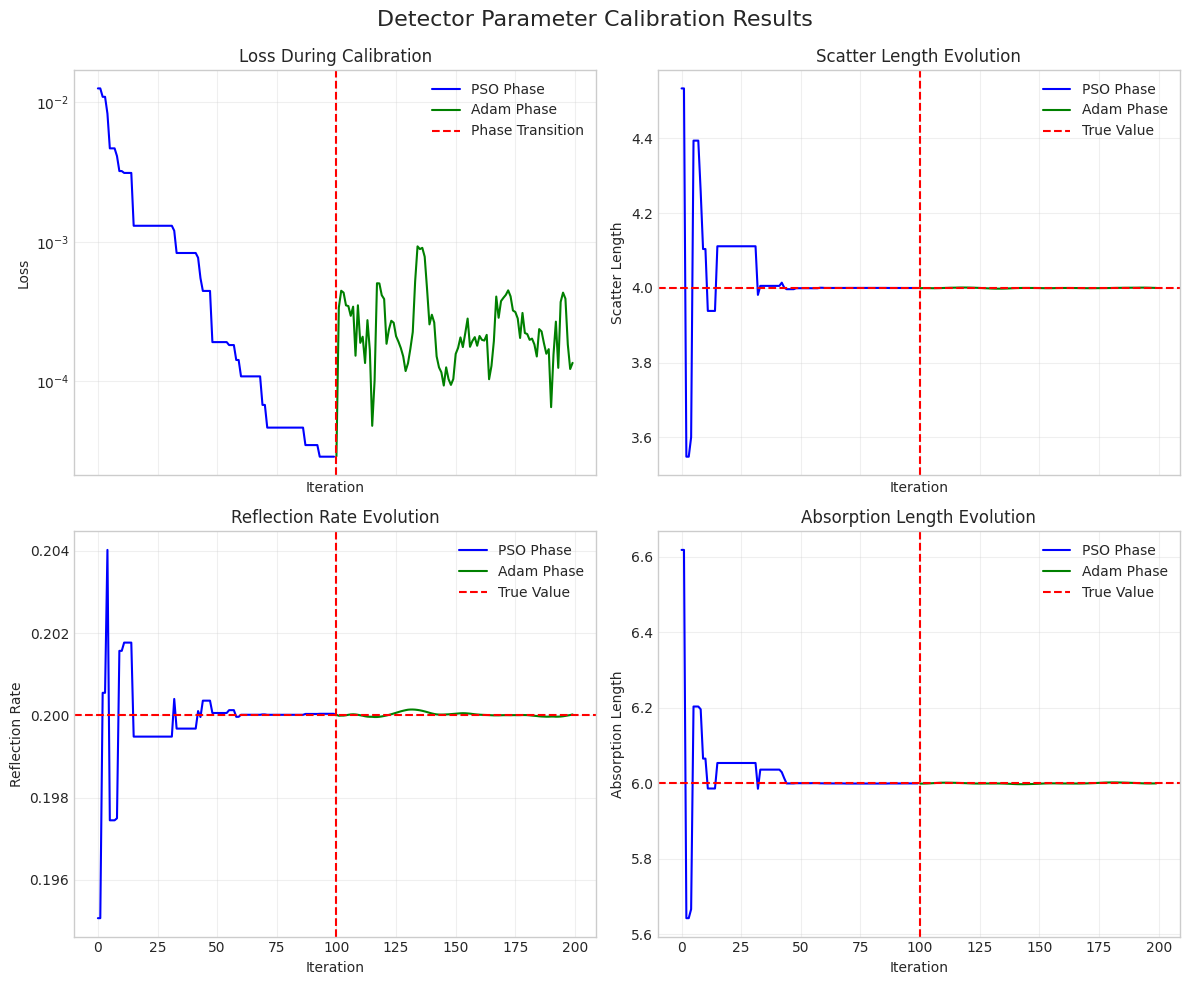


Running Test Case 2: Medium Case
Starting detector calibration...
True parameters:
  Scatter Length: 3.5000
  Reflection Rate: 0.2500
  Absorption Length: 7.0000
Running PSO with Adam refinement...
Phase 1: PSO global search...
Phase 2: Adam optimizer refinement with diagonal preconditioning...

Calibration Results:
MSE: 0.000006, Runtime: 26.58s
Scatter Length: 3.4956 (true: 3.5000, error: 0.0044)
Reflection Rate: 0.2500 (true: 0.2500, error: 0.0000)
Absorption Length: 7.0001 (true: 7.0000, error: 0.0001)
PSO Iterations: 100
Adam Iterations: 100


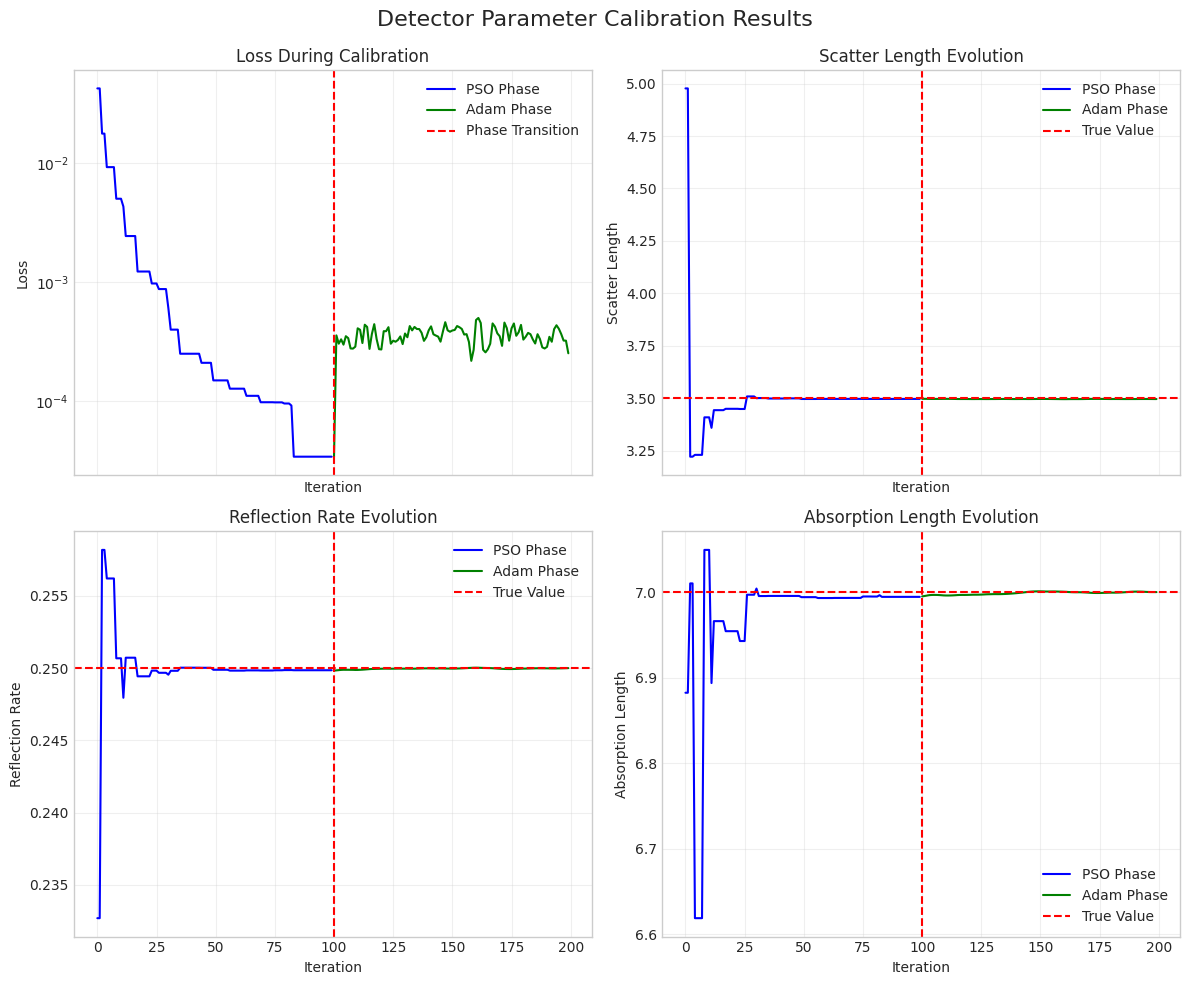


Running Test Case 3: Hard Case
Starting detector calibration...
True parameters:
  Scatter Length: 5.0000
  Reflection Rate: 0.1500
  Absorption Length: 5.0000
Running PSO with Adam refinement...
Phase 1: PSO global search...
Phase 2: Adam optimizer refinement with diagonal preconditioning...

Calibration Results:
MSE: 0.000034, Runtime: 27.00s
Scatter Length: 4.9899 (true: 5.0000, error: 0.0101)
Reflection Rate: 0.1500 (true: 0.1500, error: 0.0000)
Absorption Length: 5.0011 (true: 5.0000, error: 0.0011)
PSO Iterations: 100
Adam Iterations: 100


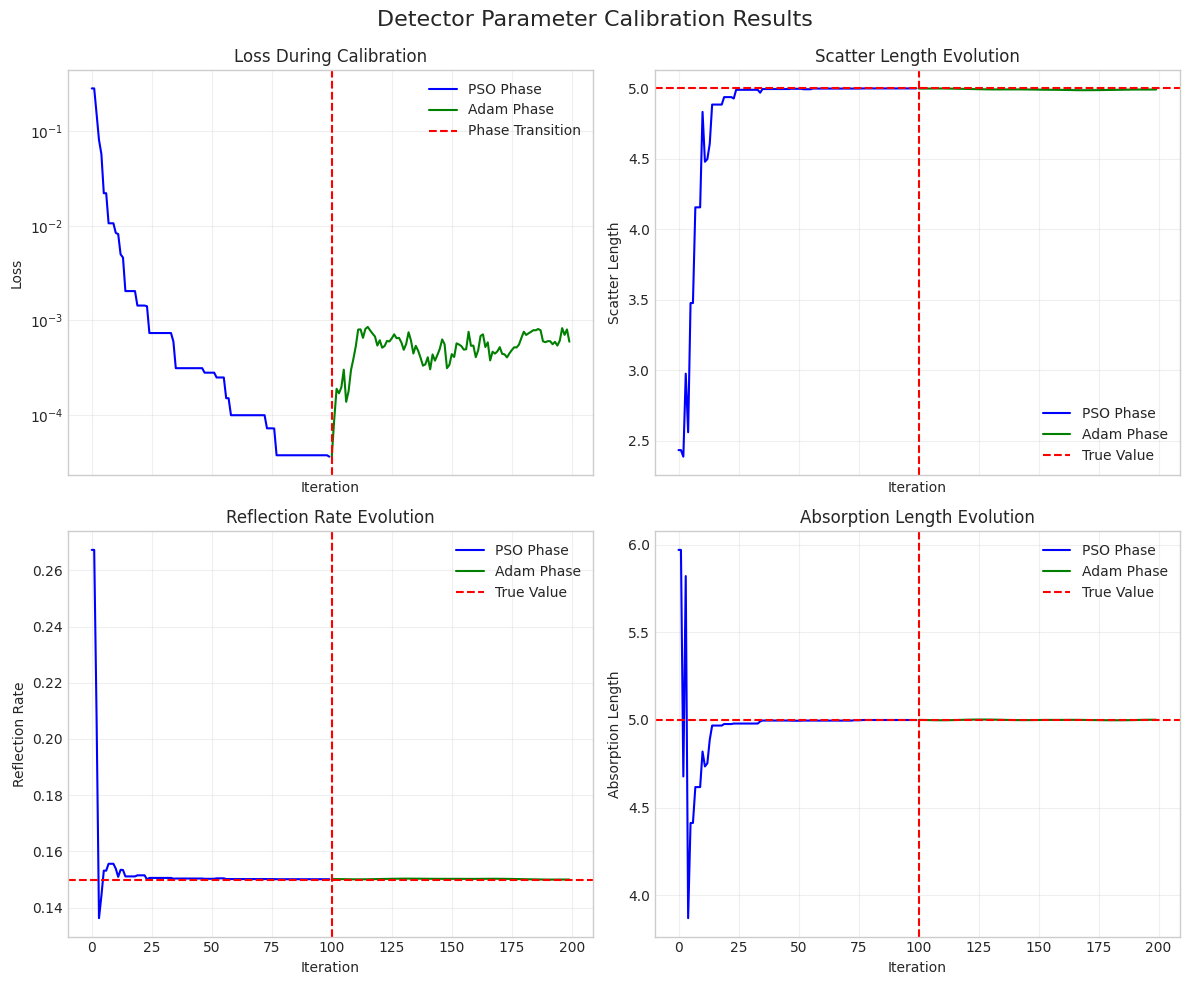


Running Test Case 4: Hard Case
Starting detector calibration...
True parameters:
  Scatter Length: 3.0000
  Reflection Rate: 0.3500
  Absorption Length: 7.5000
Running PSO with Adam refinement...
Phase 1: PSO global search...
Phase 2: Adam optimizer refinement with diagonal preconditioning...

Calibration Results:
MSE: 0.000310, Runtime: 27.15s
Scatter Length: 2.9731 (true: 3.0000, error: 0.0269)
Reflection Rate: 0.3503 (true: 0.3500, error: 0.0003)
Absorption Length: 7.4856 (true: 7.5000, error: 0.0144)
PSO Iterations: 100
Adam Iterations: 100


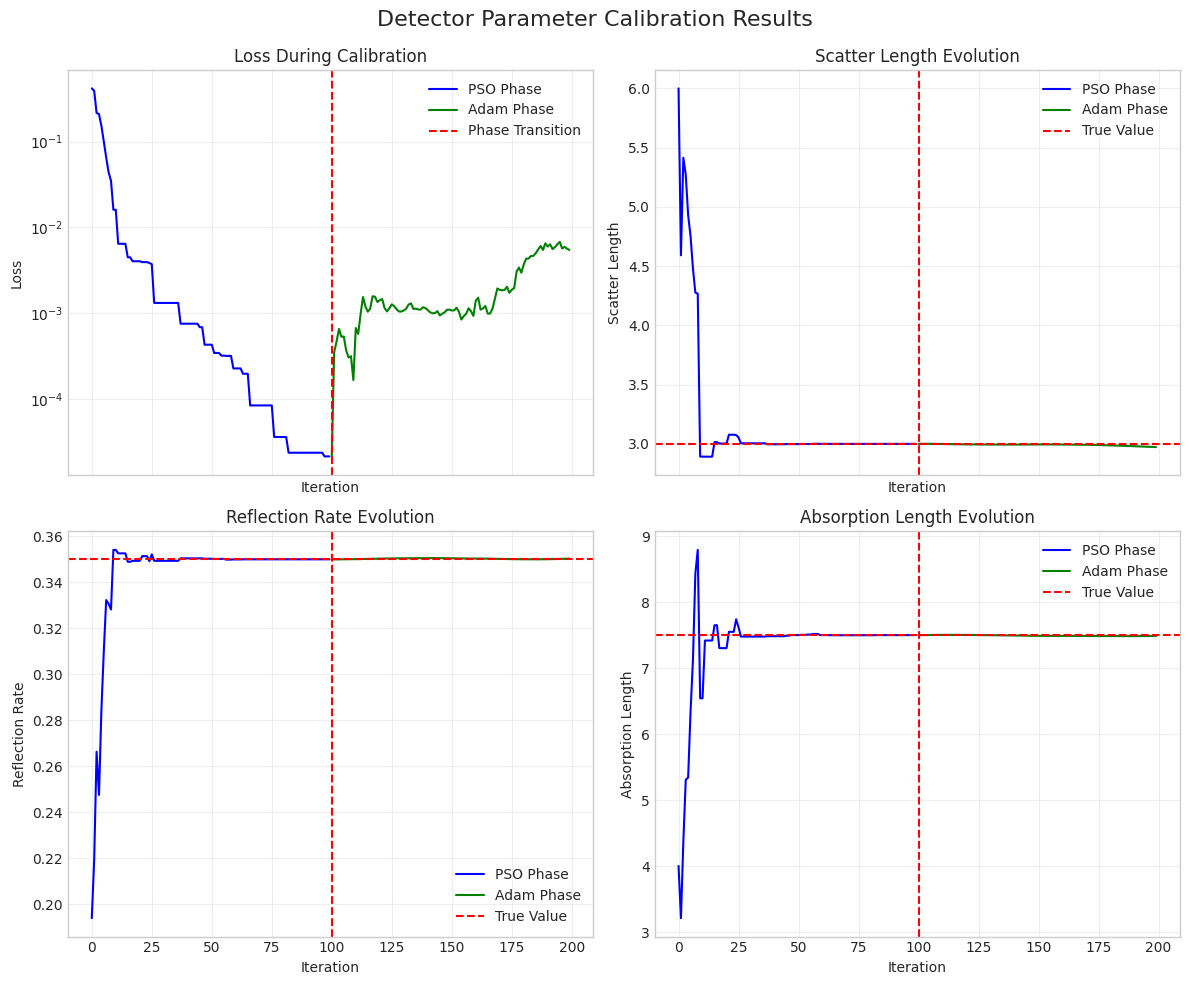


CALIBRATION SUMMARY
Case            MSE          Scatter Err  Reflect Err  Absorb Err  
----------------------------------------------------------------------
Easy Case       0.000000     0.000238     0.000021     0.000025    
Medium Case     0.000006     0.004400     0.000005     0.000110    
Hard Case       0.000034     0.010077     0.000008     0.001080    
Hard Case       0.000310     0.026898     0.000299     0.014360    


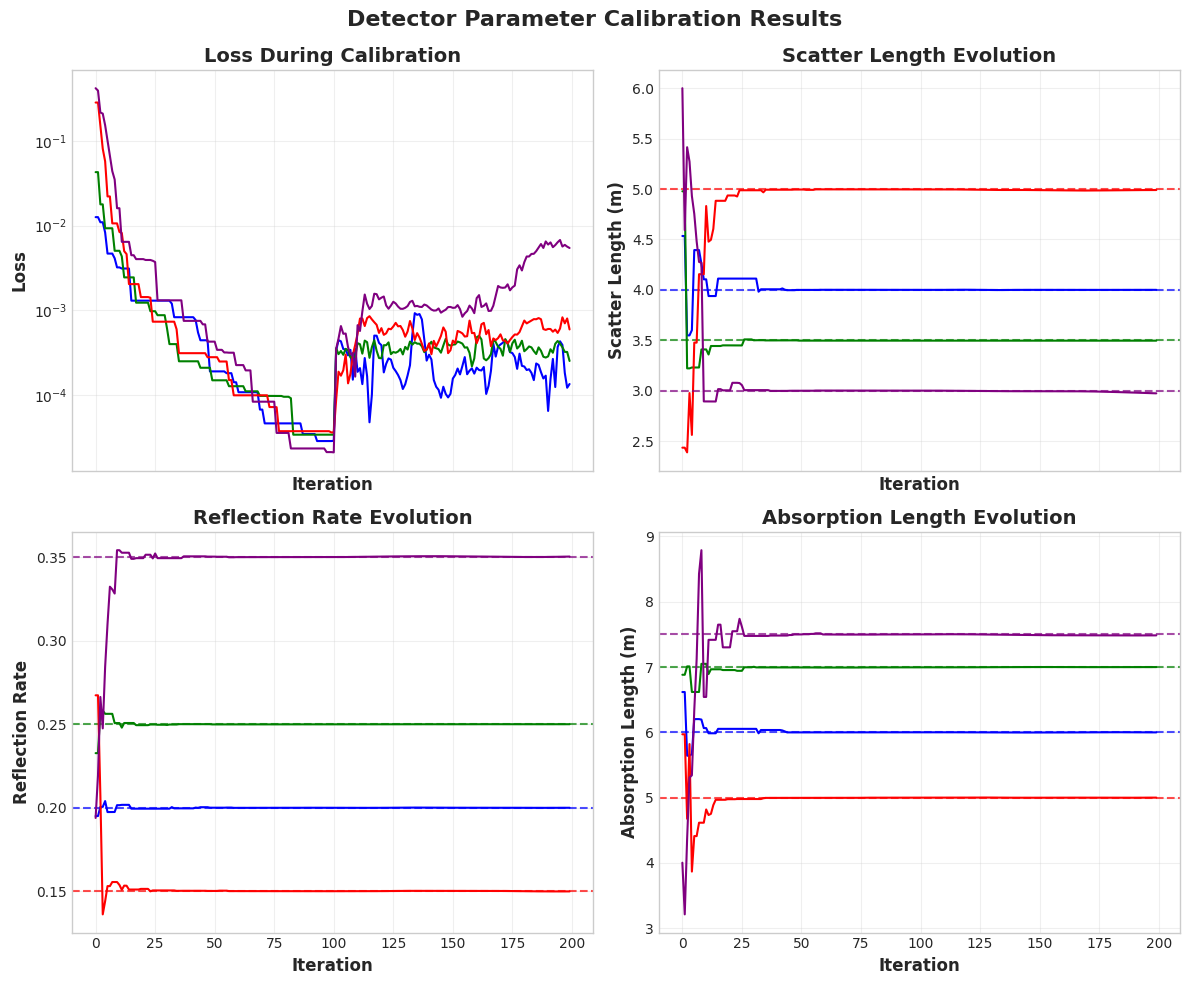

In [34]:
# Define multiple test cases
def create_test_cases():
    """Create 4 different test cases with varying conditions."""
    test_cases = []

    # Case 1: Easy case - initial guess close to true values
    case1 = {
        'name': 'Easy Case',
        'true_params': jnp.array([4.0, 0.2, 6.0, TAU_GS]),
        'initial_guess': jnp.array([3.8, 0.19, 5.8, TAU_GS]),
        'color': 'blue',
        'label': 'Easy: Close Initial Guess'
    }
    test_cases.append(case1)

    # Case 2: Medium case - moderate offset
    case2 = {
        'name': 'Medium Case',
        'true_params': jnp.array([3.5, 0.25, 7.0, TAU_GS]),
        'initial_guess': jnp.array([4.5, 0.18, 5.5, TAU_GS]),
        'color': 'green',
        'label': 'Medium: Moderate Offset'
    }
    test_cases.append(case2)

    # Case 3: Hard case - large offset
    case3 = {
        'name': 'Hard Case',
        'true_params': jnp.array([5.0, 0.15, 5.0, TAU_GS]),
        'initial_guess': jnp.array([3.0, 0.35, 8.0, TAU_GS]),
        'color': 'red',
        'label': 'Hard: Large Offset'
    }
    test_cases.append(case3)

    # Case 4: Hard case - challenging parameter values
    case4 = {
        'name': 'Hard Case',
        'true_params': jnp.array([3.0, 0.35, 7.5, TAU_GS]),
        'initial_guess': jnp.array([5.8, 0.15, 3.2, TAU_GS]),
        'color': 'purple',
        'label': 'Very Hard: Extreme Offset'
    }
    test_cases.append(case4)

    return test_cases

def run_multi_case_analysis(adam_lr=0.01, param_lr_scale=None):
    """Run the complete multi-case analysis with specified Adam parameters."""
    # Create test cases
    test_cases = create_test_cases()

    # Extract labels and colors
    labels = [case['label'] for case in test_cases]
    colors = [case['color'] for case in test_cases]

    # Run calibrations
    results_list = []
    for i, case in enumerate(test_cases):
        print(f"\n{'='*50}")
        print(f"Running Test Case {i+1}: {case['name']}")
        print(f"{'='*50}")

        # Run calibration with diagonal preconditioning
        results = run_detector_calibration(
            true_params=case['true_params'],
            initial_guess=case['initial_guess'],
            adam_lr=adam_lr,
            param_lr_scale=param_lr_scale
        )

        # Add case information to results
        results['case_name'] = case['name']
        results['color'] = case['color']
        results['label'] = case['label']
        results['initial_guess'] = case['initial_guess']

        results_list.append(results)

    # Create summary table
    create_summary_table(results_list)

    # Plot all results together
    plot_multi_calibration_results(results_list, labels, colors)

    return results_list

# Run the multi-case analysis with diagonal preconditioning
if __name__ == "__main__":
    # Define custom parameter scaling if needed
    custom_param_scale = jnp.array([1.0, 0.05, 1.0, 0.0])  # Scale down reflection by 50x

    # Run analysis with diagonal preconditioning
    results_list = run_multi_case_analysis(adam_lr=5e-4, param_lr_scale=custom_param_scale)